In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 17.8MB/s 
     |████████████████████████████████| 1.2MB 50.5MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 194kB 57.3MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

# Image Classification

## From Dogs and Cats to Pet Breeds

In [3]:
# set up imports and download Pets data 
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
#hide
# set the BASE_PATH attribute of the Path module to path 
# so that all commands like ls() are relative to path
Path.BASE_PATH = path

In [5]:
# list the dirs relative to path
# annotations describe information about where the pets are
path.ls()

(#2) [Path('images'),Path('annotations')]

In [6]:
# list everything in path/images
(path/"images").ls()

(#7393) [Path('images/miniature_pinscher_87.jpg'),Path('images/boxer_101.jpg'),Path('images/newfoundland_182.jpg'),Path('images/english_cocker_spaniel_114.jpg'),Path('images/samoyed_102.jpg'),Path('images/Russian_Blue_244.jpg'),Path('images/german_shorthaired_13.jpg'),Path('images/english_cocker_spaniel_86.jpg'),Path('images/shiba_inu_202.jpg'),Path('images/keeshond_78.jpg')...]

In [7]:
# grab one file path to see what it looks like 
fname = (path/"images").ls()[0]
fname, fname.name

(Path('images/miniature_pinscher_87.jpg'), 'miniature_pinscher_87.jpg')

In [8]:
# re - module for regular expression 
# findall() will return a list of all the strings matching pattern 
# r is used to denote a raw string in Python
# (.+) - capture any letter one or more times 
# (.+)_\d+.jpg$ - followed by underscore, digit one or more times 
# then anything followed by the letters jpg and $ ends the string 
results = re.findall(r'(.+)_\d+.jpg$', fname.name)
type(results), results

(list, ['miniature_pinscher'])

In [ ]:
?re.findall

In [9]:
# Create a Datablock 
# using_attr - using attribute which takes a function f and changes it to a 
# function which will be passed attr the attribute 
# aug_transforms - data augmentation method 
# Resize(460) - resize to a very large image 
# the use random resize crop to a smaller size in aug_transform 
# the combination of item_tfms and batch_tfms is called presizing 
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [ ]:
?using_attr

## Presizing

In [ ]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

FileNotFoundError: ignored

### Checking and Debugging a DataBlock

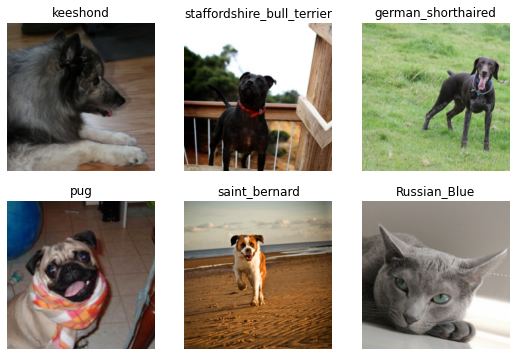

In [11]:
dls.show_batch(nrows=2, ncols=3)

In [ ]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Abyssinian_5.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=200x150
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Abyssinian_5.jpg
    applying partial gives
      Abyssinian
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=200x150, TensorCategory(0))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pi

RuntimeError: ignored

In [12]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.512035,1.042662,0.323410,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.499941,0.817650,0.264547,01:13
1,0.322893,0.789222,0.251691,01:11


In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

# Model Analysis 

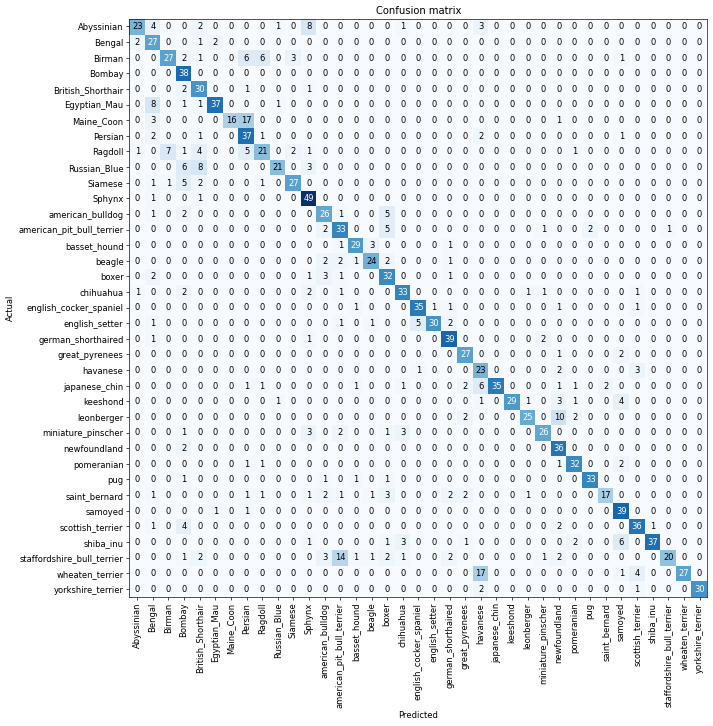

In [ ]:
# Confusion matrix 

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Cross-Entropy Loss

Cross-Entropy Loss 

### Viewing Activations and Labels

In [ ]:
# get one batch and separate into independent and dependent variables 
x,y = dls.one_batch()

In [ ]:
x.size(), x[1].size(), y.size()

(torch.Size([64, 3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([64]))

In [ ]:
# we could also 
# first(dls.train)

In [ ]:
len(dls.vocab), dls.vocab[18]

(37, 'english_cocker_spaniel')

In [ ]:
y

TensorCategory([16, 12, 30, 10,  6, 22, 28, 15, 15, 30, 20, 35, 33, 28, 31, 17, 14, 25, 24,  6, 17, 34, 28,  0, 26, 15, 16, 18, 15,  1,  7, 16, 10, 23, 30,  3, 34, 23, 28, 34,  0,  0, 35,  3, 24,  0, 17, 24,
         2, 28, 17, 33, 23, 16, 29, 25, 12,  3, 12, 13, 27, 25, 27, 12], device='cuda:0')

In [ ]:
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([3.9578e-07, 1.2381e-06, 9.9182e-08, 1.1063e-06, 6.3014e-06, 6.9311e-07, 4.8832e-08, 2.4477e-07, 1.9867e-08, 9.7039e-07, 2.4669e-06, 1.3274e-06, 2.3230e-04, 5.8919e-07, 2.9606e-06, 4.2503e-07,
        9.9960e-01, 2.5458e-07, 4.8346e-08, 4.1535e-08, 5.9909e-07, 8.1402e-08, 5.5041e-06, 5.1991e-08, 1.4869e-07, 1.8867e-06, 8.2406e-07, 9.9827e-08, 4.7318e-08, 1.0172e-04, 1.3887e-05, 1.4687e-07,
        1.1282e-07, 1.0425e-07, 1.9517e-05, 1.6911e-06, 1.6830e-06])

In [ ]:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

### Softmax

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


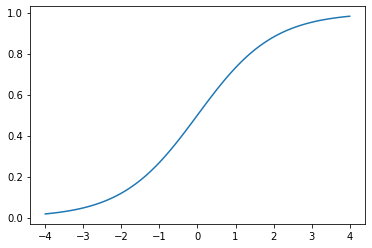

In [ ]:
# Softmax is an extension of sigmoid to more than two levels
plot_function(torch.sigmoid, min=-4,max=4)

In [ ]:
#hide
torch.random.manual_seed(42);

In [ ]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [ ]:
 acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [ ]:
s = (acts[:,0]-acts[:,1]).sigmoid()
s, 1-s

(tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661]),
 tensor([0.3975, 0.4979, 0.8668, 0.0034, 0.4041, 0.6339]))

In [ ]:
# Softmax in the binary case is identical to the sigmoid above. 
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

In [ ]:
targ = tensor([0,1,0,1,1,0])

In [ ]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [ ]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [ ]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [ ]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
# nll_loss negative log likelihood 
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the Log

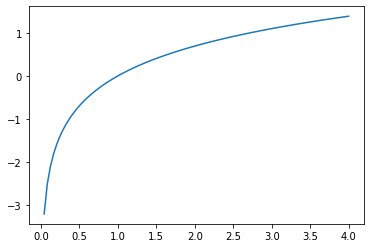

In [ ]:
plot_function(torch.log, min=0,max=4)

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_func(acts, targ)

tensor(1.8045)

In [ ]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

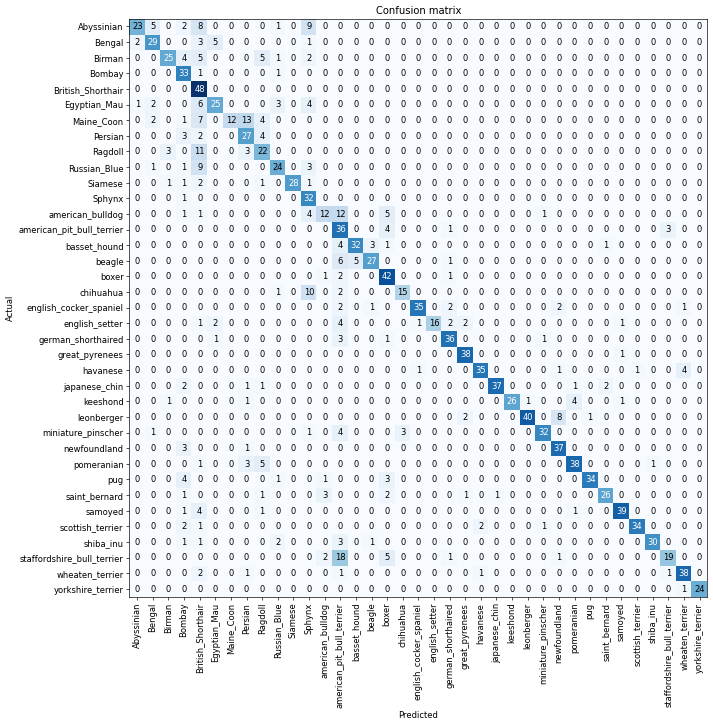

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [14]:
interp.most_confused(min_val=5)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 18),
 ('Maine_Coon', 'Persian', 13),
 ('american_bulldog', 'american_pit_bull_terrier', 12),
 ('Ragdoll', 'British_Shorthair', 11),
 ('chihuahua', 'Sphynx', 10),
 ('Abyssinian', 'Sphynx', 9),
 ('Russian_Blue', 'British_Shorthair', 9),
 ('Abyssinian', 'British_Shorthair', 8),
 ('leonberger', 'newfoundland', 8),
 ('Maine_Coon', 'British_Shorthair', 7),
 ('Egyptian_Mau', 'British_Shorthair', 6),
 ('beagle', 'american_pit_bull_terrier', 6),
 ('Abyssinian', 'Bengal', 5),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Birman', 'British_Shorthair', 5),
 ('Birman', 'Ragdoll', 5),
 ('american_bulldog', 'boxer', 5),
 ('beagle', 'basset_hound', 5),
 ('pomeranian', 'Ragdoll', 5),
 ('staffordshire_bull_terrier', 'boxer', 5)]

## Improving Our Model

### The Learning Rate Finder

In [15]:
# make our learning rate high 
# the optimizer stepped in the correct direction but overshot the minimum loss 
# and repeating this multiple times just makes us go further away. 
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.779361,9.587725,0.728011,01:07


epoch,train_loss,valid_loss,error_rate,time
0,3.268532,3.487589,0.910690,01:12


In [18]:
# what is fine_tune 
??Learner.fine_tune
# Fine tune with 'freeze' for 'freeze_epocs' then with 'unfreeze' from 'epocs' 
# using discriminative LR 


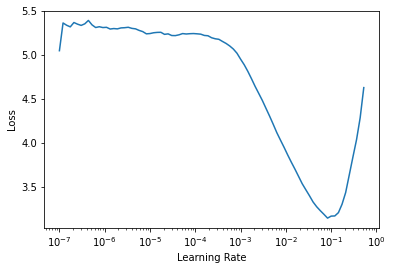

In [19]:
# Leslie Smith learning rate finder 
# two choices 
# 1. one order of magnitude less than where the minimum loss was achived 
# 2. the last point where the loss was clearly decreasing 
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [20]:
??Learner.lr_find

In [21]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 5.25e-03


In [22]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=5.25e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.132126,1.112013,0.321380,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.663587,1.116621,0.337618,01:12
1,0.374073,0.692098,0.227334,01:12


In [23]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.312679,1.015466,0.292287,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.549978,1.084112,0.305819,01:12
1,0.344440,0.828527,0.247632,01:12


### Unfreezing and Transfer Learning

In [ ]:
learn.fine_tune??
# when fine_tune is called fastai 
# 1. trains the randomly added layers for one epoch, with all other layers frozen 
# 2. Unfreezes all the layers, and trains them for the number of epochs requested 
 

In [24]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.117627,0.910275,0.261840,01:08
1,0.534331,0.901875,0.269283,01:07
2,0.322399,0.665284,0.207037,01:08


In [25]:
# Fit model for 'n_epoch' using the 1cycle policy 
?Learner.fit_one_cycle

In [27]:
# unfreeze the rest of the model, the pretrained weights 
learn.unfreeze()

In [26]:
?Learner.unfreeze()

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=9.12010818865383e-07)

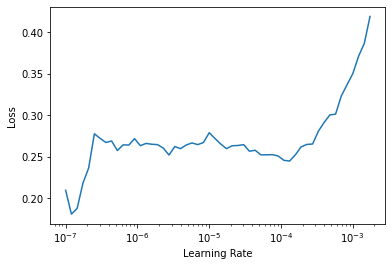

In [28]:
learn.lr_find()

In [29]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.263711,0.717325,0.226658,01:13
1,0.238416,0.655671,0.204330,01:13
2,0.222425,0.606859,0.196888,01:12
3,0.209365,0.624827,0.196888,01:11
4,0.196599,0.615195,0.194181,01:11
5,0.189783,0.584176,0.184709,01:13


### Discriminative Learning Rates

In [30]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.133961,0.750142,0.238160,01:07
1,0.535769,0.835396,0.248309,01:07
2,0.328315,0.730030,0.225981,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.259360,0.753752,0.233424,01:12
1,0.250057,0.706558,0.212449,01:12
2,0.239128,0.683496,0.207713,01:12
3,0.216861,0.720500,0.219892,01:13
4,0.185427,0.657218,0.209743,01:12
5,0.171169,0.665220,0.206360,01:11
6,0.168042,0.697037,0.217185,01:11
7,0.146929,0.658684,0.207713,01:12
8,0.147840,0.666066,0.207713,01:12
9,0.141286,0.653318,0.204330,01:13


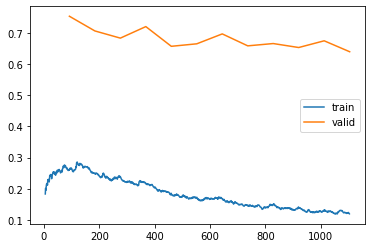

In [31]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures

In [32]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.302421,1.327294,0.394452,01:07
1,0.618168,1.274625,0.361299,01:07
2,0.424465,1.308615,0.358593,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.298182,1.003375,0.283491,01:09
1,0.305970,0.977693,0.282138,01:08
2,0.256033,0.905837,0.247632,01:08
3,0.150382,0.847447,0.240189,01:08
4,0.088111,0.738338,0.200271,01:08
5,0.054329,0.736213,0.197564,01:08


In [35]:
??DataLoader

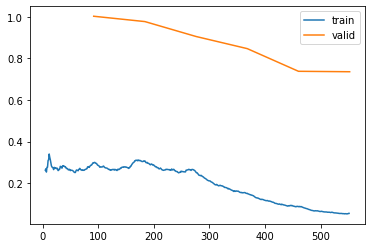

In [36]:

learn.recorder.plot_loss()

## Conclusion

## Questionnaire


1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
  * 
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions .
  * https://regexone.com/
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
  * A table of data (CSV format) in which each row is an item and may include filenames providing connections between data in the table and data in other formats. 
  * Individual files representing items of data possibly organized into folders or with filenames representing information (label) about the item.
1. Look up the documentation for `L` and try using a few of the new methods that it adds.
1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a `DataLoaders`?

  * the `show_batch()` method is used to view the data in `DataLoaders`

1. What method does fastai provide to help you debug a `DataBlock`?
  * fastai comes with `summary()` attribute which will attempt to crate a batch from the data source and print out details of this process. 

1. Should you hold off on training a model until you have thoroughly cleaned your data?
  * No, train the model as soon as possible. Training a model before cleaning has some advantages: 
    1. Your model might preform better than what you expect without having to spend time cleaning data. 
    1. A trained model can aid in the data cleaning process. 
    1. You might learn that the model you have chosen for your data set is not a good choice. 
1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
  * log_softmax and nll_loss 
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
  1. 
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.